# Energy Price Data Processing

This notebook processes raw PUN (Prezzo Unico Nazionale) energy price data for Italy:
- Loads raw data from data/raw/energy_price/Italy/PUN.csv
- Cleans and standardizes the data format
- Handles missing values and outliers
- Saves processed data to data/processed/Italy/PUN_p.csv
- Creates final dataset in data/final/Italy/energy_price2015_2024.csv
- Generates statistics and diagnostic plots

## Background
The PUN (Prezzo Unico Nazionale) is the reference price for electricity in Italy. It represents the weighted average of the prices formed on the Day-Ahead Market (MGP) for each hour, weighted according to the volumes traded in the different market zones.

This notebook processes historical PUN data to prepare it for analysis and modeling.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime as dt
from pathlib import Path

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')

## Path Configuration

Define paths for input data, processed outputs, and visualization storage. The notebook automatically creates any necessary directories.


In [2]:
# Define paths
BASE_DIR = Path().resolve().parent
RAW_DATA_PATH = BASE_DIR / 'data/raw/energy_price/Italy/PUN.csv'
PROCESSED_DIR = BASE_DIR / 'data/processed/Italy'
FINAL_DIR = BASE_DIR / 'data/final/Italy'
IMAGES_DIR = BASE_DIR / 'outputs/images'

# Create directories if they don't exist
PROCESSED_DIR.mkdir(exist_ok=True, parents=True)
FINAL_DIR.mkdir(exist_ok=True, parents=True)
IMAGES_DIR.mkdir(exist_ok=True, parents=True)

print(f"Raw data path: {RAW_DATA_PATH}")
print(f"Processed data directory: {PROCESSED_DIR}")
print(f"Final data directory: {FINAL_DIR}")
print(f"Images directory: {IMAGES_DIR}")

Raw data path: /Users/aless/Desktop/AI_ML_Projects/DataCenters/project/data/raw/energy_price/Italy/PUN.csv
Processed data directory: /Users/aless/Desktop/AI_ML_Projects/DataCenters/project/data/processed/Italy
Final data directory: /Users/aless/Desktop/AI_ML_Projects/DataCenters/project/data/final/Italy
Images directory: /Users/aless/Desktop/AI_ML_Projects/DataCenters/project/outputs/images


## Data Loading

Load the raw PUN price data from CSV file. This function handles any exceptions that might occur during loading.


In [3]:
def load_data(file_path):
    """Load raw data from CSV file"""
    print(f"Loading data from {file_path}...")
    try:
        df = pd.read_csv(file_path)
        print(f"Successfully loaded data with {df.shape[0]} rows and {df.shape[1]} columns.")
        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        raise

## Data Cleaning and Preprocessing

This section handles the cleaning and preprocessing of the raw price data:
1. Standardize column names
2. Convert date format and set as index
3. Handle missing values using a time-series appropriate approach
4. Identify outliers using the IQR method
5. Add time-based features like year, month, day, and day of week


In [4]:
def clean_data(df):
    """Clean and preprocess the data"""
    print("Cleaning and preprocessing data...")
    
    # Make a copy to avoid modifying the original
    df_clean = df.copy()
    
    # Standardize column names
    df_clean.columns = [col.strip() for col in df_clean.columns]
    
    # Check for date column
    if 'Date' not in df_clean.columns:
        raise ValueError("Required column 'Date' not found in the dataset.")
    
    # Convert date format from DD/MM/YYYY to YYYY-MM-DD
    df_clean['Date'] = pd.to_datetime(df_clean['Date'], format='%d/%m/%Y')
    
    # Set Date as index
    df_clean.set_index('Date', inplace=True)
    
    # Sort by date
    df_clean.sort_index(inplace=True)
    
    # Check for price column (€/MWh)
    price_col = '€/MWh' if '€/MWh' in df_clean.columns else None
    
    if not price_col:
        raise ValueError("Price column not found in dataset.")
    
    # Rename price column to more code-friendly name
    df_clean.rename(columns={price_col: 'price_eur_mwh'}, inplace=True)
    
    # Check for missing values
    missing_values = df_clean['price_eur_mwh'].isna().sum()
    print(f"Found {missing_values} missing values.")
    
    if missing_values > 0:
        # Handle missing values using forward fill (with a 3-day window)
        # This preserves time-series patterns better than mean/median for this type of data
        df_clean['price_eur_mwh'] = df_clean['price_eur_mwh'].fillna(method='ffill', limit=3)
        
        # If any missing values remain, use backward fill
        df_clean['price_eur_mwh'] = df_clean['price_eur_mwh'].fillna(method='bfill', limit=3)
        
        # If still any missing values remain, use median
        if df_clean['price_eur_mwh'].isna().sum() > 0:
            median_price = df_clean['price_eur_mwh'].median()
            df_clean['price_eur_mwh'] = df_clean['price_eur_mwh'].fillna(median_price)
            print(f"Filled remaining missing values with median: {median_price:.2f}")
    
    # Handle outliers using IQR method
    Q1 = df_clean['price_eur_mwh'].quantile(0.25)
    Q3 = df_clean['price_eur_mwh'].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR
    
    # Count outliers
    outliers = df_clean[(df_clean['price_eur_mwh'] < lower_bound) | 
                        (df_clean['price_eur_mwh'] > upper_bound)].shape[0]
    print(f"Found {outliers} outliers using IQR method.")
    
    # Mark outliers but keep them for transparency
    df_clean['is_outlier'] = (df_clean['price_eur_mwh'] < lower_bound) | (df_clean['price_eur_mwh'] > upper_bound)
    
    # Add year, month columns for easier analysis
    df_clean['year'] = df_clean.index.year
    df_clean['month'] = df_clean.index.month
    df_clean['day'] = df_clean.index.day
    
    # Add day of week
    df_clean['day_of_week'] = df_clean.index.dayofweek
    df_clean['is_weekend'] = df_clean['day_of_week'].isin([5, 6])  # 5=Saturday, 6=Sunday
    
    return df_clean

## Final Dataset Creation

Create the final dataset by:
1. Filtering to include only data from 2015-2024
2. Resetting the index to make date a column again
3. Converting the date back to string format for better compatibility with various tools


In [5]:
def create_final_dataset(df):
    """Create the final dataset with any transformations needed"""
    print("Creating final dataset...")
    
    # Copy the processed data
    df_final = df.copy()
    
    # Filter to keep only data from 2015-2024
    current_year = dt.datetime.now().year
    df_final = df_final[(df_final.index.year >= 2015) & (df_final.index.year <= current_year)]
    
    # Reset index to make date a column
    df_final.reset_index(inplace=True)
    
    # Convert back to string format YYYY-MM-DD for better compatibility
    df_final['Date'] = df_final['Date'].dt.strftime('%Y-%m-%d')
    
    return df_final

## Statistical Analysis

Generate and display basic statistics for the price data:
1. Summary statistics (count, mean, std, min, 25%, 50%, 75%, max)
2. Yearly averages
3. Monthly averages across all years
4. Weekday vs. Weekend price comparisons


In [6]:
def generate_statistics(df):
    """Generate and print basic statistics"""
    print("\nBasic Statistics:")
    print("-" * 40)
    
    # Summary statistics
    stats = df['price_eur_mwh'].describe()
    print(stats)
    
    # Get yearly averages
    yearly_avg = df.groupby('year')['price_eur_mwh'].mean()
    print("\nYearly Averages:")
    print(yearly_avg)
    
    # Get monthly averages across all years
    monthly_avg = df.groupby('month')['price_eur_mwh'].mean()
    print("\nMonthly Averages (across all years):")
    print(monthly_avg)
    
    # Weekday vs Weekend averages
    weekday_avg = df[~df['is_weekend']]['price_eur_mwh'].mean()
    weekend_avg = df[df['is_weekend']]['price_eur_mwh'].mean()
    
    print(f"\nWeekday Average: {weekday_avg:.2f} €/MWh")
    print(f"Weekend Average: {weekend_avg:.2f} €/MWh")
    
    return stats

## Visualization Generation

Create diagnostic plots to visualize the price data:
1. Time series plot showing price trends over time
2. Yearly box plots showing price distribution by year
3. Monthly box plots showing seasonal patterns
4. Distribution plot showing the overall price distribution
5. Outlier visualization highlighting detected outliers


In [7]:
def generate_plots(df, images_dir):
    """Generate diagnostic plots"""
    print("Generating diagnostic plots...")
    
    # Time series plot
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['price_eur_mwh'], color='blue', alpha=0.7)
    plt.title('Energy Price Time Series (2015-2024)', fontsize=14)
    plt.xlabel('Date')
    plt.ylabel('Price (€/MWh)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(images_dir / 'price_timeseries.png', dpi=300)
    plt.show()
    
    # Yearly box plots
    plt.figure(figsize=(14, 8))
    sns.boxplot(x='year', y='price_eur_mwh', data=df)
    plt.title('Energy Price Distribution by Year', fontsize=14)
    plt.xlabel('Year')
    plt.ylabel('Price (€/MWh)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(images_dir / 'yearly_price_distribution.png', dpi=300)
    plt.show()
    
    # Monthly box plots
    plt.figure(figsize=(14, 8))
    sns.boxplot(x='month', y='price_eur_mwh', data=df)
    plt.title('Energy Price Distribution by Month', fontsize=14)
    plt.xlabel('Month')
    plt.ylabel('Price (€/MWh)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(images_dir / 'monthly_price_distribution.png', dpi=300)
    plt.show()
    
    # Distribution plot
    plt.figure(figsize=(12, 6))
    sns.histplot(df['price_eur_mwh'], kde=True, bins=30)
    plt.title('Energy Price Distribution', fontsize=14)
    plt.xlabel('Price (€/MWh)')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(images_dir / 'price_distribution.png', dpi=300)
    plt.show()
    
    # Outlier visualization
    if 'is_outlier' in df.columns and df['is_outlier'].sum() > 0:
        plt.figure(figsize=(12, 6))
        plt.scatter(df.index, df['price_eur_mwh'], 
                   c=df['is_outlier'].map({True: 'red', False: 'blue'}),
                   alpha=0.7)
        plt.title('Energy Price Outliers', fontsize=14)
        plt.xlabel('Date')
        plt.ylabel('Price (€/MWh)')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(images_dir / 'price_outliers.png', dpi=300)
        plt.show()
    
    print(f"Plots saved to {images_dir}")

## Execute the Data Processing Pipeline

Run the complete data processing pipeline:
1. Load the raw data
2. Clean and preprocess the data
3. Create the final dataset
4. Generate statistics
5. Create visualizations
6. Save the processed and final datasets


In [8]:
# Load data
df_raw = load_data(RAW_DATA_PATH)

# Display the first few rows of the raw data
print("\nRaw data preview:")
df_raw.head()

Loading data from /Users/aless/Desktop/AI_ML_Projects/DataCenters/project/data/raw/energy_price/Italy/PUN.csv...
Successfully loaded data with 3653 rows and 2 columns.

Raw data preview:


,Date,€/MWh
0,01/01/2015,45.472115
1,02/01/2015,56.988056
2,03/01/2015,50.532976
3,04/01/2015,45.106388
4,05/01/2015,53.368481


In [9]:
# Clean data
df_processed = clean_data(df_raw)

# Display the first few rows of the processed data
print("\nProcessed data preview:")
df_processed.head()

Cleaning and preprocessing data...
Found 0 missing values.
Found 145 outliers using IQR method.

Processed data preview:


,price_eur_mwh,is_outlier,year,month,day,day_of_week,is_weekend
Date,,,,,,,
2015-01-01,45.472115,False,2015,1,1,3,False
2015-01-02,56.988056,False,2015,1,2,4,False
2015-01-03,50.532976,False,2015,1,3,5,True
2015-01-04,45.106388,False,2015,1,4,6,True
2015-01-05,53.368481,False,2015,1,5,0,False


In [10]:
# Create final dataset
df_final = create_final_dataset(df_processed)

# Display the first few rows of the final data
print("\nFinal data preview:")
df_final.head()

Creating final dataset...

Final data preview:


,Date,price_eur_mwh,is_outlier,year,month,day,day_of_week,is_weekend
0,2015-01-01,45.472115,False,2015,1,1,3,False
1,2015-01-02,56.988056,False,2015,1,2,4,False
2,2015-01-03,50.532976,False,2015,1,3,5,True
3,2015-01-04,45.106388,False,2015,1,4,6,True
4,2015-01-05,53.368481,False,2015,1,5,0,False


In [11]:
# Generate statistics
stats = generate_statistics(df_processed)


Basic Statistics:
----------------------------------------
count    3653.000000
mean       96.647910
std        90.098071
min        10.659308
25%        47.397251
50%        60.367120
75%       112.136641
max       740.091314
Name: price_eur_mwh, dtype: float64

Yearly Averages:
year
2015     52.305648
2016     42.775691
2017     53.949572
2018     61.309365
2019     52.325940
2020     38.916242
2021    125.448122
2022    303.965806
2023    127.235484
2024    108.520469
Name: price_eur_mwh, dtype: float64

Monthly Averages (across all years):
month
1      89.279140
2      81.506187
3      86.493757
4      78.701583
5      75.162610
6      83.275874
7     108.264926
8     119.901802
9     113.850344
10    100.604919
11    104.575191
12    116.640159
Name: price_eur_mwh, dtype: float64

Weekday Average: 100.47 €/MWh
Weekend Average: 87.10 €/MWh


Generating diagnostic plots...


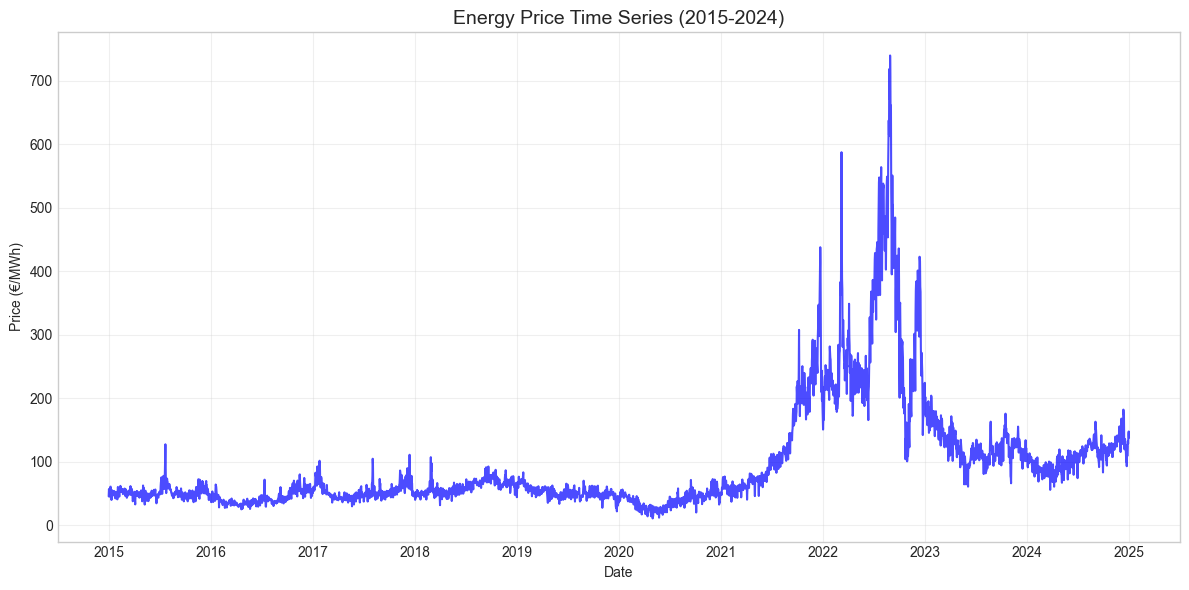

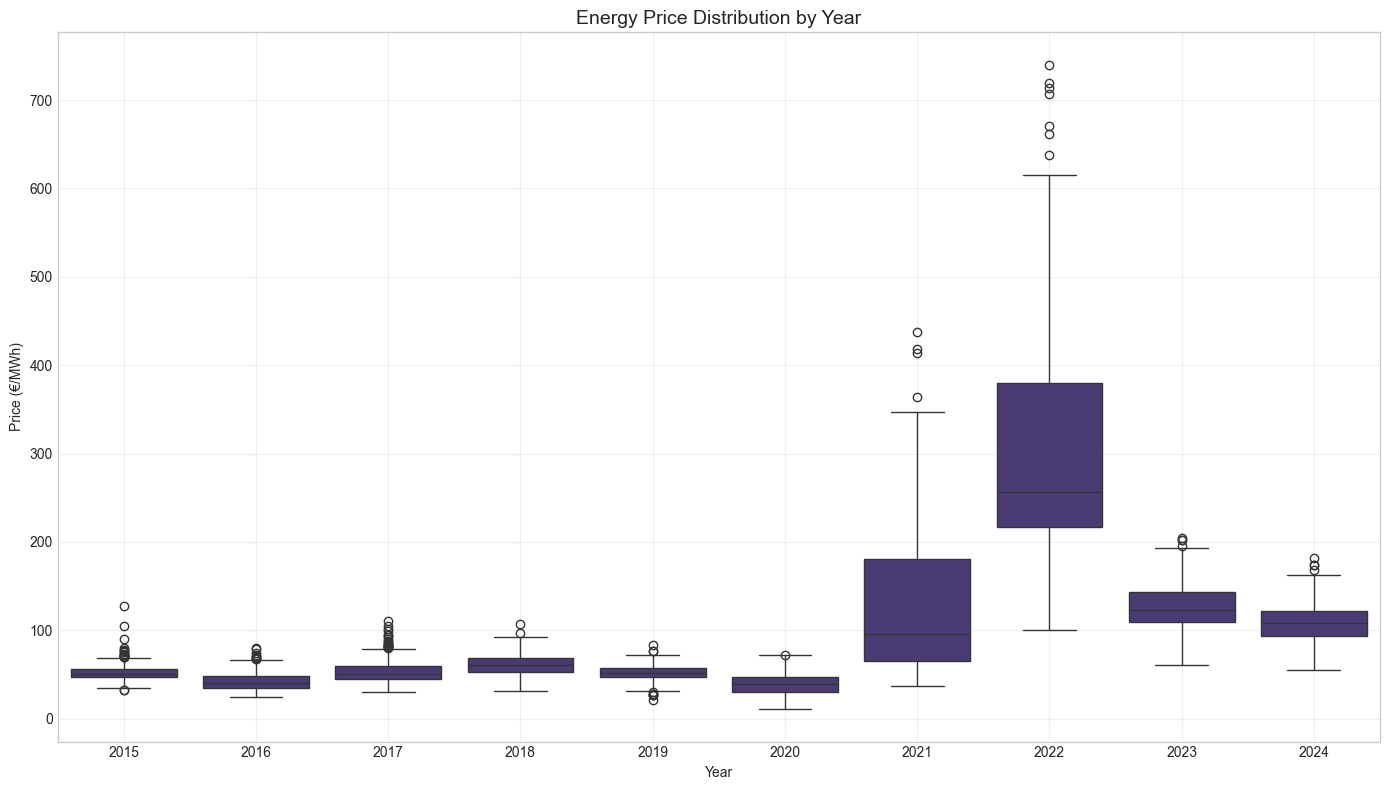

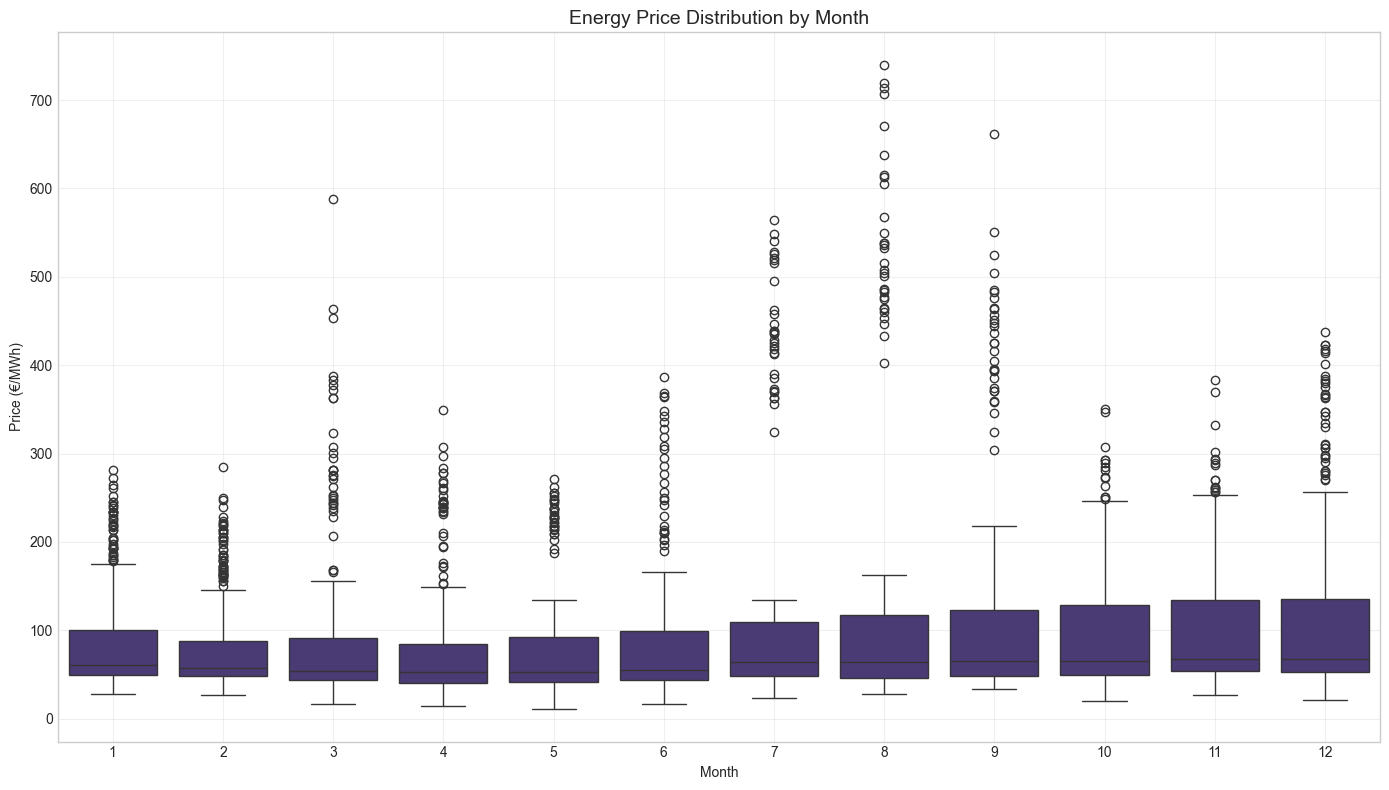

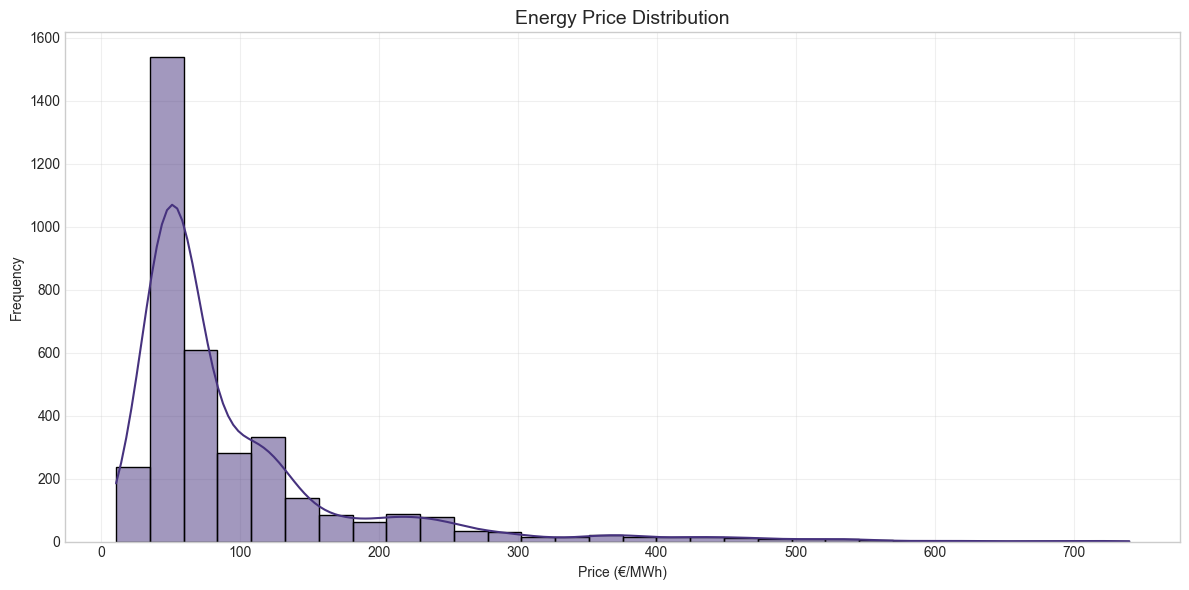

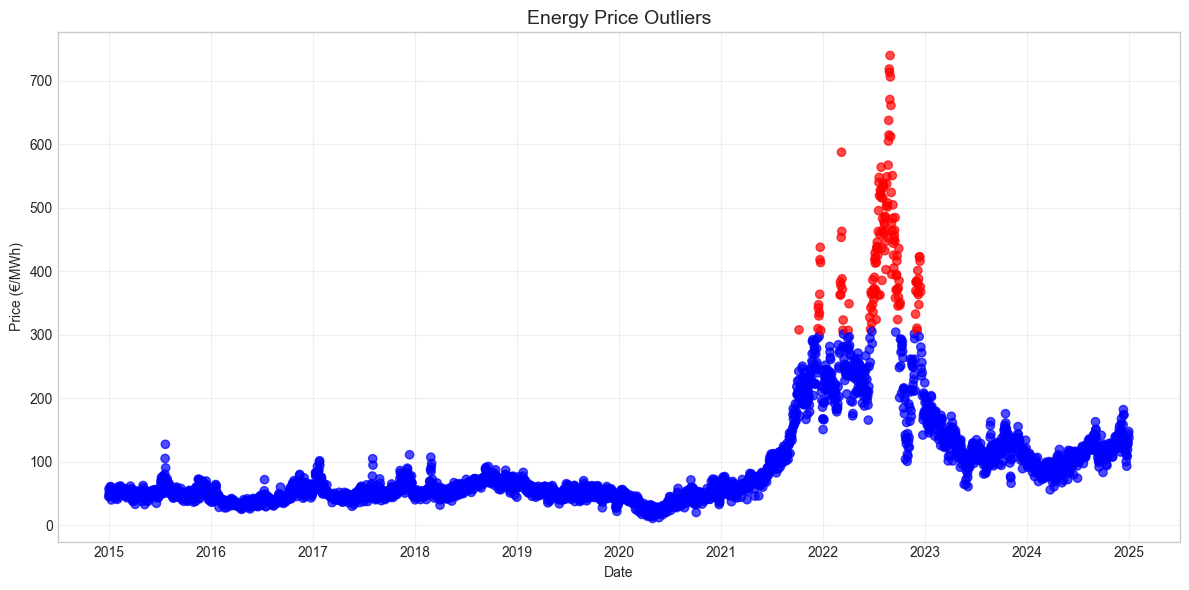

Plots saved to /Users/aless/Desktop/AI_ML_Projects/DataCenters/project/outputs/images


In [12]:
# Generate plots
generate_plots(df_processed, IMAGES_DIR)

In [13]:
# Save processed data
processed_path = PROCESSED_DIR / 'PUN_p.csv'
df_processed.to_csv(processed_path)
print(f"Processed data saved to {processed_path}")

# Save final data
final_path = FINAL_DIR / 'energy_price2015_2024.csv'
df_final.to_csv(final_path, index=False)
print(f"Final data saved to {final_path}")

print("Price data processing complete!")

Processed data saved to /Users/aless/Desktop/AI_ML_Projects/DataCenters/project/data/processed/Italy/PUN_p.csv
Final data saved to /Users/aless/Desktop/AI_ML_Projects/DataCenters/project/data/final/Italy/energy_price2015_2024.csv
Price data processing complete!


## Conclusion

This notebook has successfully:
1. Loaded the raw PUN price data for Italy
2. Cleaned and preprocessed the data, handling missing values and outliers
3. Created a final dataset focused on the 2015-2024 period
4. Generated statistical summaries and visualizations
5. Saved both processed and final datasets for further analysis

The processed data can now be used for:
- Exploratory data analysis (EDA)
- Time series forecasting
- Correlation analysis with other energy market variables
- Feature engineering for predictive models

### Next Steps
- Conduct detailed exploratory data analysis (see notebook `01_eda_price.ipynb`)
- Train forecasting models (see notebook `02_train_price_model.py`)
- Analyze correlations with demand and RES generation data
